# Sanity check for STDP visualizing
Les poids sont fixes et non plus normaux, pour faciliter la visualisation

## D'après le super papier de Froemke and Dan 2002 :
A+ = 103 %, A- = 51%

theta+ = 13.3 ms, theta- = 34.5ms

# 1/ Visualiser les poids du ring après son apprentissage

In [1]:
simtime = 2000

In [2]:
import numpy as np
import pyNN.nest as sim
from pyNN.random import NumpyRNG
from pyNN.random import RandomDistribution as rnd
import matplotlib.pyplot as plt
from lmfit.models import GaussianModel
import lmfit
import matplotlib.gridspec as gridspec

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/usr/local/lib/python3.7/site-packages/pyNN/nest/__init__.py:55: UserWarning: Unable to install NEST extensions. Certain models may not be available.
Further details: DynamicModuleManagementError in Install: Module 'pynn_extensions' could not be opened.
The dynamic loader returned the following error: 'file not found'.

Please check LD_LIBRARY_PATH (OSX: DYLD_LIBRARY_PATH)!
  warnings.warn("Unable to install NEST extensions. Certain models may not be available.\nFurther details: {}".format(err))


In [3]:
def fit_plot(popsize, spike_array, ax, datacol = '.r', fitcol = '--k', data_kws = None, do_title = True,
            seq_nbr= None):
    '''
    calculates a spike array gaussian lmfit profile and plots it
    '''
    #extracts the spiketrains
    
    #fit the gaussian
    x = np.linspace(0, popsize, popsize)
    y = spike_array

    mod = GaussianModel()
    pars = mod.guess(y, x=x)
    #pars['center'] = lmfit.Parameter('center', seq_nbr*15)
    out = mod.fit(y, pars, x=x)
    #print(out.fit_report(min_correl=0.25))
    
    #plot the fits
    out.plot_fit(ax = ax, datafmt = datacol, fitfmt = fitcol, data_kws = data_kws)
    
    #eye cancer-triggering lines
    sigma = out.best_values['sigma']

    
    if do_title :
        ax.set_title('Sequence #%s -- ' % seq_nbr + r'$\sigma$ = %.2f'%sigma)
    
    return ax, sigma
    
def tuning_function(i, j, B, N): #von mises
        if B==np.inf:
            VM = np.ones_like(i*j)
        else:
            VM = np.exp((np.cos(2.*((i-j)/N*np.pi))-1)/(B*np.pi/180)**2)
        VM /= VM.sum(axis=0)
        return VM
    
def vary_angle(t):
    '''
    callback function that shifts the maximum angle
    '''
    
    n_pop = 60
    shift = 40
    noise = .2
    
    angle = 1. * np.arange(n_pop)
    rates = tuning_function(angle, (t*shift)+(angle_input)/180.*n_pop, b_theta, n_pop)
    rates /= rates.mean()
    rates = (1-noise)*rates + noise
    rates *= rate_gain
    for i, cell in enumerate(input_pop):
        cell.set_parameters(rate=rates[i])
        
    return t + simtime/4

def cut_spiketrain(array, window):
    '''
    Cut a spiketrain array between window*500 and window+1 *500
    we use it to only visualize a specific time window of the network
    '''
    spiketrain_len = []
    for spiketrain in np.asarray(array.spiketrains):
        spiketrain_array = np.array(spiketrain, dtype = float)
        
        spiketrain_cut = np.where((spiketrain_array > window*500) & (spiketrain_array < (window+1)*500))[0]
        
        spiketrain_len.append(len(spiketrain_cut))
    
    spikelen_array = np.asarray(spiketrain_len)
    return spikelen_array

In [4]:
def SuperPlotter(SpikesP, SpikesE, SpikesI, 
                 popsize, rates, simtime,
                 title = 'Title', markersize = .5,
                         figsize = (9,6), shifts = None):
        def plot_spiketrains(ax, spikes, color, ylabel, do_ticks): #oh la jolie double fonction
            for spiketrain in spikes.spiketrains:
                y = np.ones_like(spiketrain) * spiketrain.annotations['source_id']
                ax.scatter(spiketrain, y, color = color, s = markersize)
                ax.set_ylabel(ylabel)
                if not do_ticks : ax.set_xticklabels([])
                if shifts != None :
                    for i, times in enumerate(shifts): ax.axvline(x = times, color = 'k',
                                                                 linestyle = '-.', linewidth = 1)
                        
        fig = plt.figure(figsize = figsize)
        gs = gridspec.GridSpec(3, 8)
        axs1 = plt.subplot(gs[0, :4])
        axs2 = plt.subplot(gs[1, :4])
        axs3 = plt.subplot(gs[2, :4])
        
        axs4 = plt.subplot(gs[0:1 , 4:6])
        axs5 = plt.subplot(gs[0:1 , 6:8])
        axs6 = plt.subplot(gs[1:2 , 4:6])
        axs7 = plt.subplot(gs[1:2 , 6:8])
        
        #what a fucking mess
        min_poisson = int(SpikesP.description.split('ID range')[1].split('\n')[0].split(': ')[1].split('-')[0])
        max_poisson = int(SpikesP.description.split('ID range')[1].split('\n')[0].split(': ')[1].split('-')[1])
        axs1.set_ylim(min_poisson, max_poisson)
        
        plot_spiketrains(axs1, SpikesP, color = 'g', ylabel = 'Neuron Index', do_ticks = False)
        axs1.set_title('Poisson input')
        plot_spiketrains(axs2, SpikesI, color = 'b', ylabel = 'Neuron Index', do_ticks = False)
        axs2.set_title('Inhibitory population')
        plot_spiketrains(axs3, SpikesE, color = 'r', ylabel = 'Neuron Index', do_ticks = True)
        axs3.set_title('Excitatory population')
        axs3.set_xlabel('Time(ms)')
        
        axs4.plot(cut_spiketrain(SpikesP, 0), color = 'g')
        fit_plot(popsize, cut_spiketrain(SpikesE, 0) , axs4, seq_nbr = 1)[1]
        axs4.set_xticklabels([])
        axs4.set_yticklabels([])
        axs4.set_xlabel('')
        axs4.set_ylabel('')
        
        axs5.plot(cut_spiketrain(SpikesP, 1), color = 'g')
        fit_plot(popsize, cut_spiketrain(SpikesE, 1) , axs5, seq_nbr = 2)[1]
        axs5.set_xticklabels([])
        axs5.set_yticklabels([])
        axs5.set_xlabel('')
        axs5.set_ylabel('')
        
        axs6.plot(cut_spiketrain(SpikesP, 2), color = 'g')
        fit_plot(popsize, cut_spiketrain(SpikesE, 2) , axs6, seq_nbr = 3)[1]
        axs6.set_xticklabels([])
        axs6.set_yticklabels([])
        axs6.set_xlabel('')
        axs6.set_ylabel('')
        
        axs7.plot(cut_spiketrain(SpikesP, 3), color = 'g')
        fit_plot(popsize, cut_spiketrain(SpikesE, 3) , axs7, seq_nbr = 4)[1]
        axs7.set_xlabel('Neuron index')
        axs7.set_ylabel('Sequence spikes', rotation = 270)
        axs7.yaxis.tick_right()
        axs7.yaxis.set_label_position("right")
        
        fig.suptitle(title, fontsize=12)
        plt.show()
        return fig

# Simulation

In [5]:
n_pop = 60
neuron_parameters = {'cm': .5,  # nF - McCormick
                     'e_rev_E': 0.0,  # mV - McCormick but default values
                     'e_rev_I': -70.0,  # mV - McCormick but default values
                     'tau_m': 30,  # ms - Markram
                     'tau_refrac': 1.5,  # ms - McCormick
                     'tau_syn_E': 0.25,  # ms -McCormick
                     'tau_syn_I': 0.75,  # ms - McCormick
                     'v_reset': -56.5,  # mV - McCormick
                     'v_rest': -65.5,  # mV - McCormick
                     'v_thresh': -52.5,  # mV - McCormick
                     }

rng = sim.NumpyRNG(seed=42)

rate_gain = 10.  # multiplier for the rates
angle_input = 40  # degrees
b_theta = 30  # degrees
sparseness = .5

In [6]:
sim.SpikePairRule?

Init signature: sim.SpikePairRule(tau_plus=20.0, tau_minus=20.0, A_plus=0.01, A_minus=0.01)
Docstring:     
The amplitude of the weight change depends only on the relative timing of
spike pairs, not triplets, etc. All possible spike pairs are taken into
account (cf Song and Abbott).

Arguments:
    `tau_plus`:
        time constant of the positive part of the STDP curve, in milliseconds.
    `tau_minus`
        time constant of the negative part of the STDP curve, in milliseconds.
    `A_plus`:
        amplitude of the positive part of the STDP curve.
    `A_minus`:
        amplitude of the negative part of the STDP curve.
Init docstring: Create a new specification for the timing-dependence of an STDP rule.
File:           /usr/local/lib/python3.7/site-packages/pyNN/nest/standardmodels/synapses.py
Type:           type
Subclasses:     


In [7]:
weight_inp_exc, weight_inp_inh = .8, .1
weight_inh_inh, weight_inh_exc = .5, 2.8
stdp_weight_init = 1./60

#delay_exc_exc, delay_inh_inh, delay_exc_inh, delay_inh_ex = 2., 3., 4., 4.
delay_inp_exc, delay_inp_inh = 1., 4.
#normal_weights = stdp_weight_init

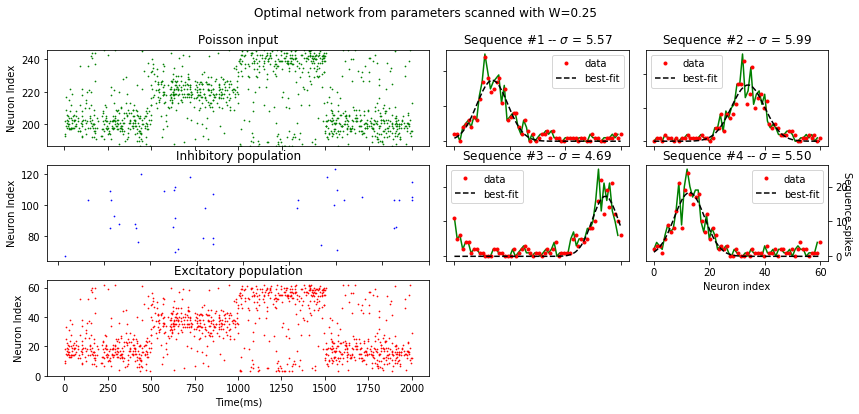

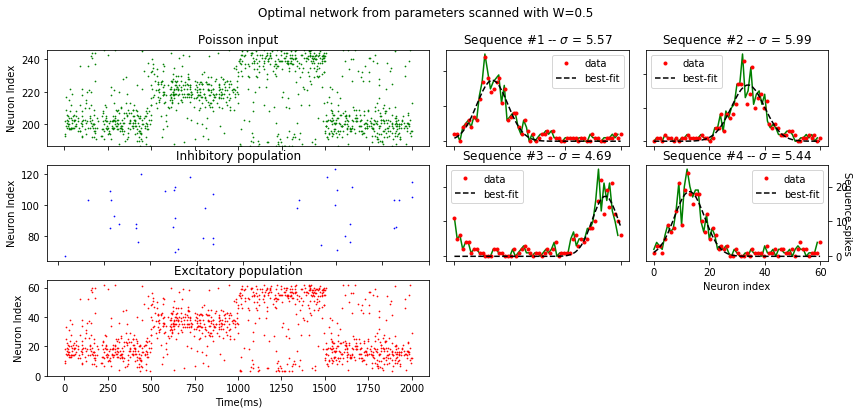

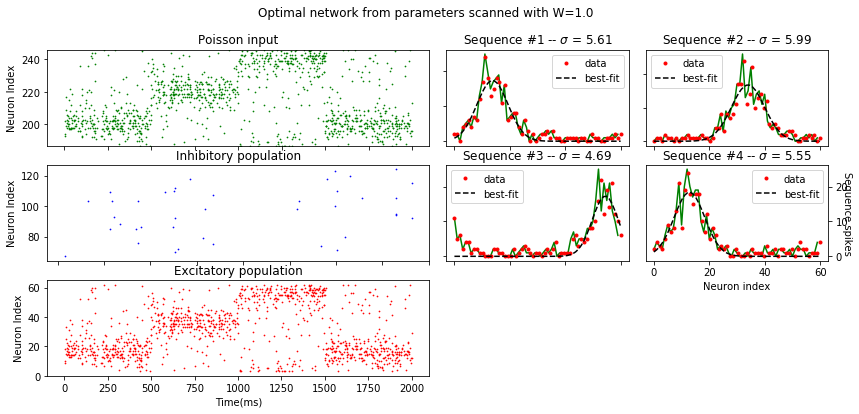

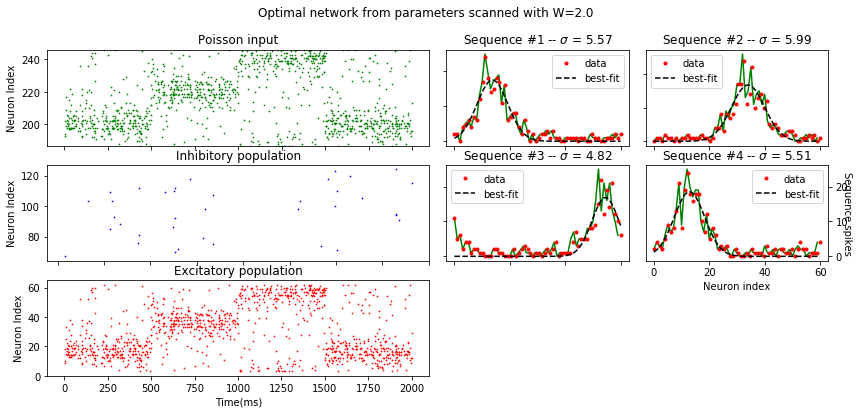

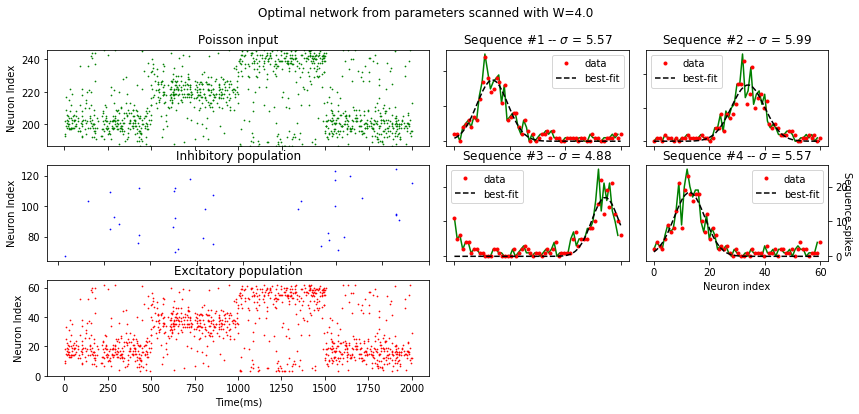

In [8]:
for W in np.logspace(-1, 1, 5, base=4):

    delays = rnd('normal_clipped', mu=1, sigma=.5, low=0.1,
                 high=5,
                 rng=rng)

    causal_hebbian_rule = sim.SpikePairRule(tau_plus=30., tau_minus=30.,
                                          A_plus=.01*W, A_minus=.012*W)
    anticausal_hebbian_rule = sim.SpikePairRule(tau_plus=30., tau_minus=30.,
                                          A_plus=-.01*W, A_minus=-.01*W)
    sym_hebbian_rule = sim.SpikePairRule(tau_plus=30., tau_minus=30.,
                                          A_plus=.01*W, A_minus=-.012*W)
    antisym_hebbian_rule = sim.SpikePairRule(tau_plus=30., tau_minus=30.,
                                          A_plus=-.01*W, A_minus=.012*W)


    stdp_max_w = 8 * stdp_weight_init

    sim.setup(timestep=.1, threads=4)
    exc = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                         initial_values={"v": neuron_parameters["v_reset"]},
                         label="Neurones Exictateurs")

    inh = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                         initial_values={"v": neuron_parameters["v_reset"]},
                         label="Neurones Inhibiteurs")

    input_pop = sim.Population(n_pop,
                               sim.SpikeSourcePoisson(
                                   rate=1500, duration=simtime, start=0),
                               label="Entree Orientation")


    causal_STDP_syn = sim.STDPMechanism(
        timing_dependence=causal_hebbian_rule,
        weight_dependence=sim.AdditiveWeightDependence(w_min=0, w_max=stdp_max_w),
        #weight_dependence=sim.MultiplicativeWeightDependence(w_min=0, w_max=stdp_max_w),
        weight=stdp_weight_init,
        delay=delays,
        #          delay="0.2 + 0.01*d",
        dendritic_delay_fraction=1.)

    anticausal_STDP_syn = sim.STDPMechanism(
        timing_dependence=anticausal_hebbian_rule,
        #weight_dependence=sim.AdditiveWeightDependence(w_min=0, w_max=stdp_max_w),
        weight_dependence=sim.MultiplicativeWeightDependence(w_min=0, w_max=stdp_max_w),
        weight=stdp_weight_init,
        delay=delays,
        #          delay="0.2 + 0.01*d",
        dendritic_delay_fraction=1.)
    
    # Intras-iso
    syn_exc_exc = sim.Projection(exc, exc,
                                 connector=sim.FixedProbabilityConnector(
                                     sparseness, rng=rng),
                                 synapse_type=causal_STDP_syn,
                                 receptor_type='excitatory')
    syn_inh_inh = sim.Projection(inh, inh,
                                 connector=sim.FixedProbabilityConnector(
                                     sparseness, rng=rng),
                                 synapse_type=sim.StaticSynapse(
                                     weight=weight_inh_inh, delay=delays),
                                 receptor_type='inhibitory')  # we can't have two types of synapses now can we ?

    # Intras-cross
    syn_exc_inh = sim.Projection(exc, inh,
                                 connector=sim.FixedProbabilityConnector(
                                     sparseness, rng=rng),
                                 synapse_type=anticausal_STDP_syn,
                                 receptor_type='excitatory')
    syn_inh_ex = sim.Projection(inh, exc,
                                connector=sim.FixedProbabilityConnector(
                                    sparseness, rng=rng),
                                synapse_type=sim.StaticSynapse(
                                     weight=weight_inh_exc, delay=delays),
                                receptor_type='inhibitory')

    # Input
    syn_inp_exc = sim.Projection(input_pop, exc,
                                 connector=sim.OneToOneConnector(),
                                 #synapse_type=causal_STDP_syn,
                                 synapse_type=sim.StaticSynapse(
                                     weight=weight_inp_exc, delay=delay_inp_exc),
                                 receptor_type='excitatory')

    syn_inp_inh = sim.Projection(input_pop, inh,
                                 connector=sim.FixedProbabilityConnector(
                                     sparseness, rng=rng),
                                 #connector=sim.OneToOneConnector(),
                                 synapse_type=anticausal_STDP_syn,
                                 #synapse_type=sim.StaticSynapse(
                                 #    weight=weight_inp_inh, delay=delay_inp_inh),
                                 receptor_type='excitatory')

    angle = 1. * np.arange(n_pop)
    rates = tuning_function(angle, angle_input/180.*n_pop, b_theta, n_pop)
    rates /= rates.mean()
    rates *= rate_gain
    for i, cell in enumerate(input_pop):
        cell.set_parameters(rate=rates[i])

    exc.record('spikes')
    inh.record('spikes')
    input_pop.record('spikes')
    sim.run(simtime, callbacks=[vary_angle])
    sim.end()

    exc_data = exc.get_data().segments[0]
    inh_data = inh.get_data().segments[0]
    inp_data = input_pop.get_data().segments[0]

    fig = SuperPlotter(inp_data, exc_data, inh_data,
                 60, rates, simtime,
                 title= f'Optimal network from parameters scanned with W={W}',
                 figsize = (14,6)
                 )
    #fit_plot(n_pop, exc_data)

    plt.show()
    #fig.savefig('./figs/2018_12_11_Optim_ring_shifts.pdf', format = 'pdf', dpi = 200)

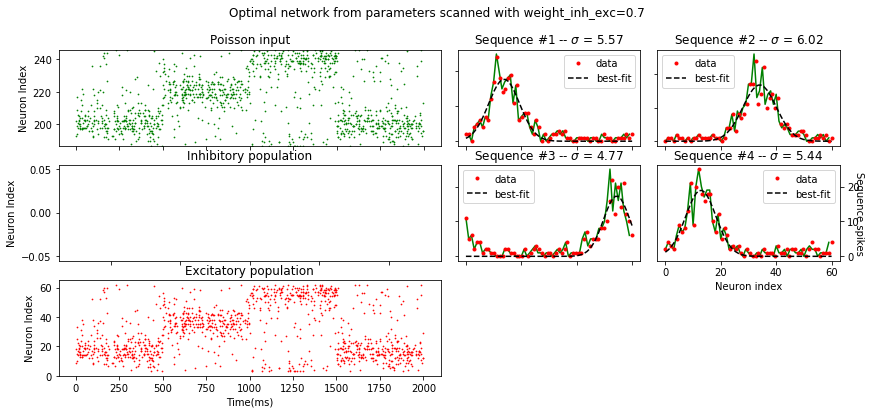

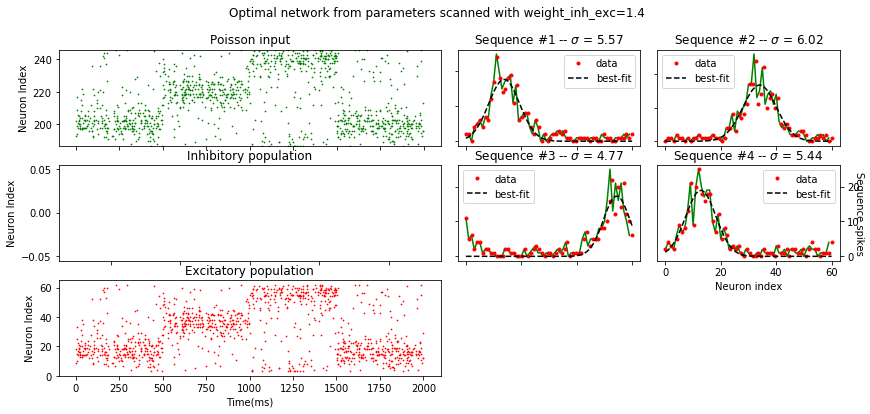

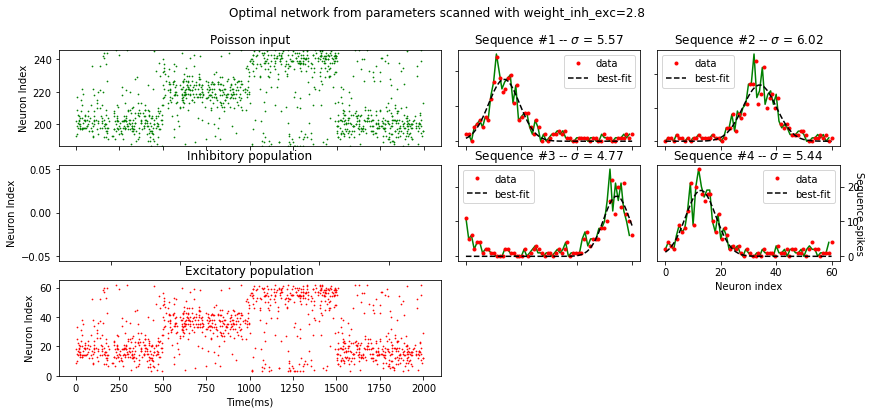

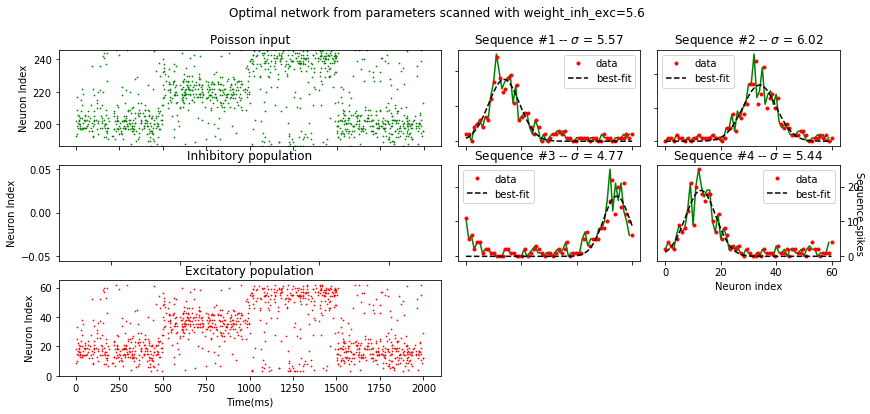

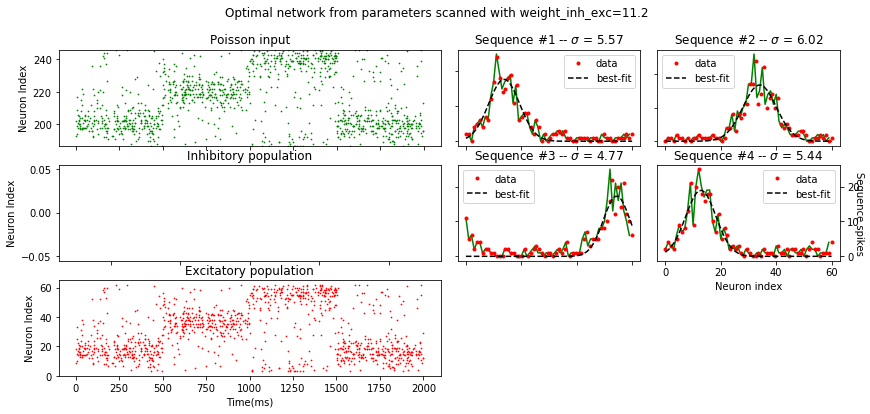

In [9]:
for weight_inh_exc_ in weight_inh_exc*np.logspace(-1, 1, 5, base=4):
    W = 1.

    #normal_weights = stdp_weight_init

    delays = rnd('normal_clipped', mu=1, sigma=.5, low=0.1,
                 high=5,
                 rng=rng)

    causal_hebbian_rule = sim.SpikePairRule(tau_plus=30., tau_minus=30.,
                                          A_plus=.01*W, A_minus=.012*W)
    anticausal_hebbian_rule = sim.SpikePairRule(tau_plus=30., tau_minus=30.,
                                          A_plus=-.01*W, A_minus=-.01*W)


    stdp_max_w = 8 * stdp_weight_init

    sim.setup(timestep=.1, threads=4)
    exc = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                         initial_values={"v": neuron_parameters["v_reset"]},
                         label="Neurones Exictateurs")

    inh = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                         initial_values={"v": neuron_parameters["v_reset"]},
                         label="Neurones Inhibiteurs")

    input_pop = sim.Population(n_pop,
                               sim.SpikeSourcePoisson(
                                   rate=1500, duration=simtime, start=0),
                               label="Entree Orientation")


    causal_STDP_syn = sim.STDPMechanism(
        timing_dependence=causal_hebbian_rule,
        #weight_dependence=sim.AdditiveWeightDependence(w_min=0, w_max=stdp_max_w),
        weight_dependence=sim.MultiplicativeWeightDependence(w_min=0, w_max=stdp_max_w),
        weight=stdp_weight_init,
        delay=delays,
        #          delay="0.2 + 0.01*d",
        dendritic_delay_fraction=1.)

    anticausal_STDP_syn = sim.STDPMechanism(
        timing_dependence=anticausal_hebbian_rule,
        weight_dependence=sim.AdditiveWeightDependence(w_min=0, w_max=stdp_max_w),
        #weight_dependence=sim.MultiplicativeWeightDependence(w_min=0, w_max=stdp_max_w),
        weight=stdp_weight_init,
        delay=delays,
        #          delay="0.2 + 0.01*d",
        dendritic_delay_fraction=1.)
    # Intras-iso
    syn_exc_exc = sim.Projection(exc, exc,
                                 connector=sim.FixedProbabilityConnector(
                                     sparseness, rng=rng),
                                 synapse_type=causal_STDP_syn,
                                 receptor_type='excitatory')
    syn_inh_inh = sim.Projection(inh, inh,
                                 connector=sim.FixedProbabilityConnector(
                                     sparseness, rng=rng),
                                 synapse_type=sim.StaticSynapse(
                                     weight=weight_inh_inh, delay=delays),
                                 receptor_type='inhibitory')  # we can't have two types of synapses now can we ?

    # Intras-cross
    syn_exc_inh = sim.Projection(exc, inh,
                                 connector=sim.FixedProbabilityConnector(
                                     sparseness, rng=rng),
                                 synapse_type=anticausal_STDP_syn,
                                 receptor_type='excitatory')
    syn_inh_ex = sim.Projection(inh, exc,
                                connector=sim.FixedProbabilityConnector(
                                    sparseness, rng=rng),
                                synapse_type=sim.StaticSynapse(
                                     weight=weight_inh_exc_, delay=delays),
                                receptor_type='inhibitory')

    # Input
    syn_inp_exc = sim.Projection(input_pop, exc,
                                 connector=sim.OneToOneConnector(),
                                 #synapse_type=causal_STDP_syn,
                                 synapse_type=sim.StaticSynapse(
                                     weight=weight_inp_exc, delay=delay_inp_exc),
                                 receptor_type='excitatory')

    syn_inp_inh = sim.Projection(input_pop, inh,
                                 connector=sim.OneToOneConnector(),
                                 synapse_type=anticausal_STDP_syn,
                                 #synapse_type=sim.StaticSynapse(
                                 #    weight=weight_inp_inh, delay=delay_inp_inh),
                                 receptor_type='excitatory')

    angle = 1. * np.arange(n_pop)
    rates = tuning_function(angle, angle_input/180.*n_pop, b_theta, n_pop)
    rates /= rates.mean()
    rates *= rate_gain
    for i, cell in enumerate(input_pop):
        cell.set_parameters(rate=rates[i])

    exc.record('spikes')
    inh.record('spikes')
    input_pop.record('spikes')
    sim.run(simtime, callbacks=[vary_angle])
    sim.end()

    exc_data = exc.get_data().segments[0]
    inh_data = inh.get_data().segments[0]
    inp_data = input_pop.get_data().segments[0]

    fig = SuperPlotter(inp_data, exc_data, inh_data,
                 60, rates, simtime,
                 title= f'Optimal network from parameters scanned with weight_inh_exc={weight_inh_exc_}',
                 figsize = (14,6)
                 )
    #fit_plot(n_pop, exc_data)

    plt.show()
    #fig.savefig('./figs/2018_12_11_Optim_ring_shifts.pdf', format = 'pdf', dpi = 200)

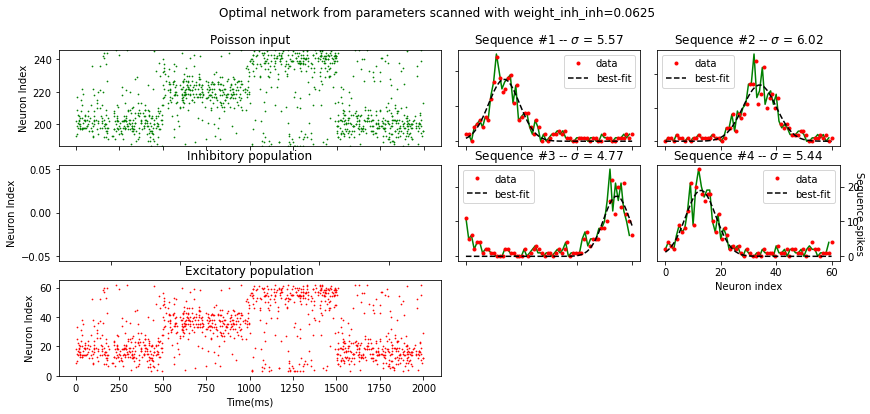

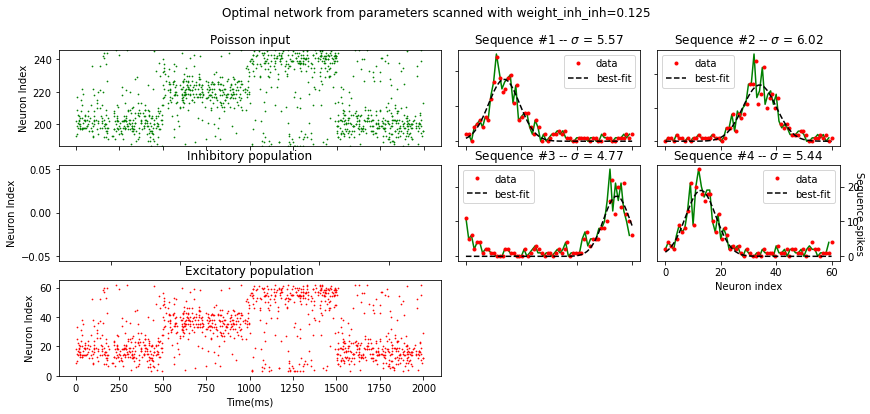

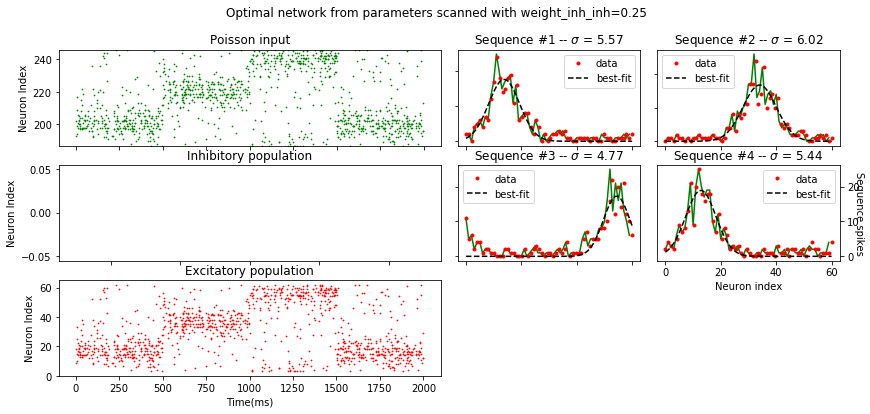

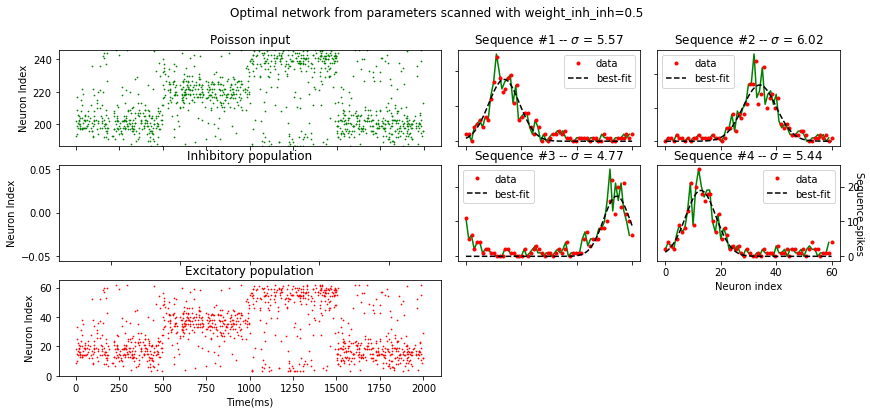

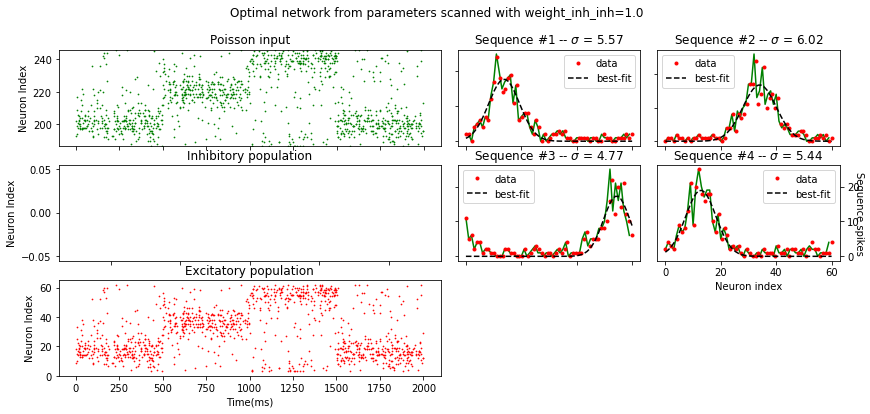

In [10]:
for weight_inh_inh_ in weight_inh_inh*np.logspace(-1, 1, 5, base=4):
    W = 1
    delays = rnd('normal_clipped', mu=1, sigma=.5, low=0.1,
                 high=5,
                 rng=rng)

    causal_hebbian_rule = sim.SpikePairRule(tau_plus=30., tau_minus=30.,
                                          A_plus=.01*W, A_minus=.012*W)
    anticausal_hebbian_rule = sim.SpikePairRule(tau_plus=30., tau_minus=30.,
                                          A_plus=-.01*W, A_minus=-.01*W)


    stdp_max_w = 8 * stdp_weight_init

    sim.setup(timestep=.1, threads=4)
    exc = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                         initial_values={"v": neuron_parameters["v_reset"]},
                         label="Neurones Exictateurs")

    inh = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                         initial_values={"v": neuron_parameters["v_reset"]},
                         label="Neurones Inhibiteurs")

    input_pop = sim.Population(n_pop,
                               sim.SpikeSourcePoisson(
                                   rate=1500, duration=simtime, start=0),
                               label="Entree Orientation")


    causal_STDP_syn = sim.STDPMechanism(
        timing_dependence=causal_hebbian_rule,
        #weight_dependence=sim.AdditiveWeightDependence(w_min=0, w_max=stdp_max_w),
        weight_dependence=sim.MultiplicativeWeightDependence(w_min=0, w_max=stdp_max_w),
        weight=stdp_weight_init,
        delay=delays,
        #          delay="0.2 + 0.01*d",
        dendritic_delay_fraction=1.)

    anticausal_STDP_syn = sim.STDPMechanism(
        timing_dependence=anticausal_hebbian_rule,
        weight_dependence=sim.AdditiveWeightDependence(w_min=0, w_max=stdp_max_w),
        #weight_dependence=sim.MultiplicativeWeightDependence(w_min=0, w_max=stdp_max_w),
        weight=stdp_weight_init,
        delay=delays,
        #          delay="0.2 + 0.01*d",
        dendritic_delay_fraction=1.)
    # Intras-iso
    syn_exc_exc = sim.Projection(exc, exc,
                                 connector=sim.FixedProbabilityConnector(
                                     sparseness, rng=rng),
                                 synapse_type=causal_STDP_syn,
                                 receptor_type='excitatory')
    syn_inh_inh = sim.Projection(inh, inh,
                                 connector=sim.FixedProbabilityConnector(
                                     sparseness, rng=rng),
                                 synapse_type=sim.StaticSynapse(
                                     weight=weight_inh_inh_, delay=delays),
                                 receptor_type='inhibitory')  # we can't have two types of synapses now can we ?

    # Intras-cross
    syn_exc_inh = sim.Projection(exc, inh,
                                 connector=sim.FixedProbabilityConnector(
                                     sparseness, rng=rng),
                                 synapse_type=anticausal_STDP_syn,
                                 receptor_type='excitatory')
    syn_inh_ex = sim.Projection(inh, exc,
                                connector=sim.FixedProbabilityConnector(
                                    sparseness, rng=rng),
                                synapse_type=sim.StaticSynapse(
                                     weight=weight_inh_exc, delay=delays),
                                receptor_type='inhibitory')

    # Input
    syn_inp_exc = sim.Projection(input_pop, exc,
                                 connector=sim.OneToOneConnector(),
                                 #synapse_type=causal_STDP_syn,
                                 synapse_type=sim.StaticSynapse(
                                     weight=weight_inp_exc, delay=delay_inp_exc),
                                 receptor_type='excitatory')

    syn_inp_inh = sim.Projection(input_pop, inh,
                                 connector=sim.OneToOneConnector(),
                                 synapse_type=anticausal_STDP_syn,
                                 #synapse_type=sim.StaticSynapse(
                                 #    weight=weight_inp_inh, delay=delay_inp_inh),
                                 receptor_type='excitatory')

    angle = 1. * np.arange(n_pop)
    rates = tuning_function(angle, angle_input/180.*n_pop, b_theta, n_pop)
    rates /= rates.mean()
    rates *= rate_gain
    for i, cell in enumerate(input_pop):
        cell.set_parameters(rate=rates[i])

    exc.record('spikes')
    inh.record('spikes')
    input_pop.record('spikes')
    sim.run(simtime, callbacks=[vary_angle])
    sim.end()

    exc_data = exc.get_data().segments[0]
    inh_data = inh.get_data().segments[0]
    inp_data = input_pop.get_data().segments[0]

    fig = SuperPlotter(inp_data, exc_data, inh_data,
                 60, rates, simtime,
                 title= f'Optimal network from parameters scanned with weight_inh_inh={weight_inh_inh_}',
                 figsize = (14,6)
                 )
    #fit_plot(n_pop, exc_data)

    plt.show()
    #fig.savefig('./figs/2018_12_11_Optim_ring_shifts.pdf', format = 'pdf', dpi = 200)

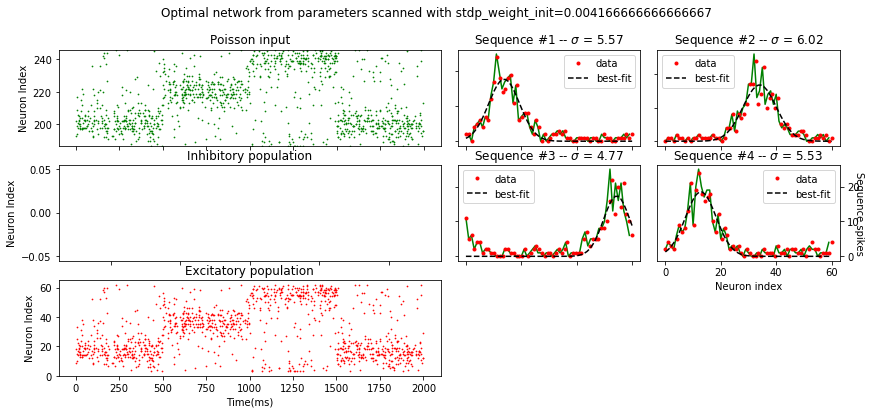

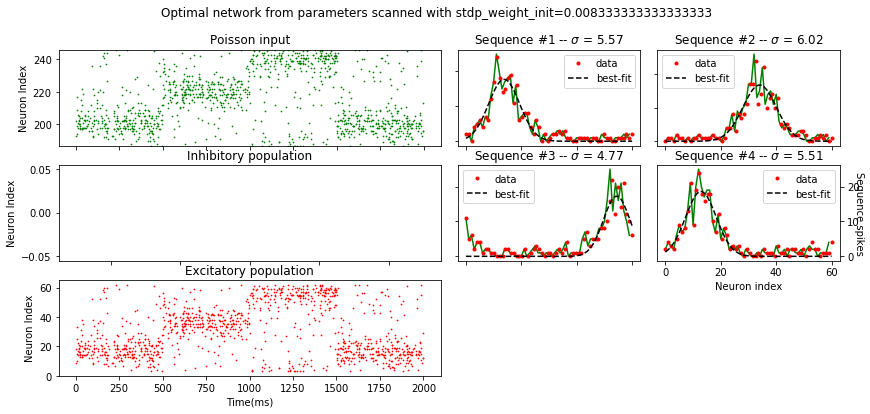

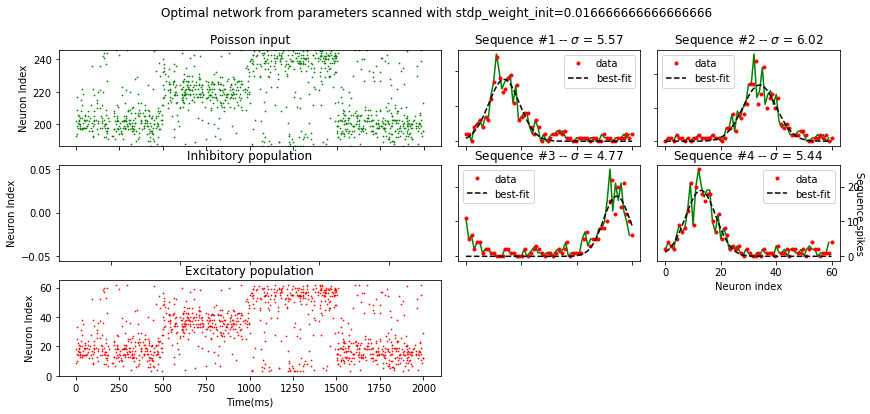

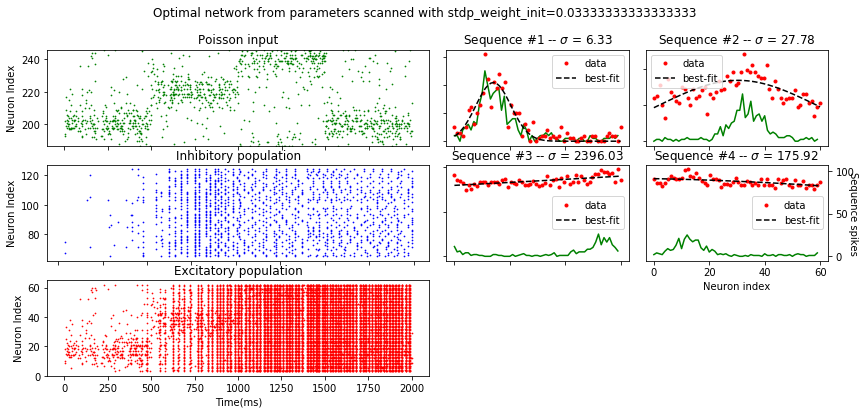

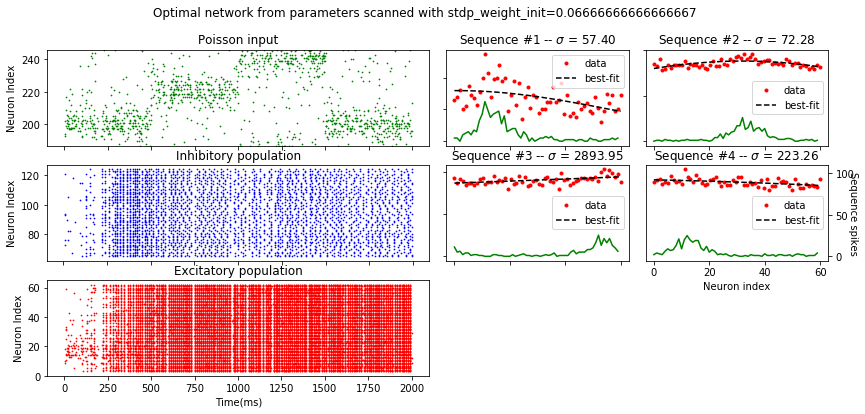

In [14]:
for stdp_weight_init_ in stdp_weight_init*np.logspace(-1, 1, 5, base=4):
    W = 1
    delays = rnd('normal_clipped', mu=1, sigma=.5, low=0.1,
                 high=5,
                 rng=rng)

    causal_hebbian_rule = sim.SpikePairRule(tau_plus=30., tau_minus=30.,
                                          A_plus=.01*W, A_minus=.012*W)
    anticausal_hebbian_rule = sim.SpikePairRule(tau_plus=30., tau_minus=30.,
                                          A_plus=-.01*W, A_minus=-.01*W)


    stdp_max_w = 8 * stdp_weight_init_

    sim.setup(timestep=.1, threads=4)
    exc = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                         initial_values={"v": neuron_parameters["v_reset"]},
                         label="Neurones Exictateurs")

    inh = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                         initial_values={"v": neuron_parameters["v_reset"]},
                         label="Neurones Inhibiteurs")

    input_pop = sim.Population(n_pop,
                               sim.SpikeSourcePoisson(
                                   rate=1500, duration=simtime, start=0),
                               label="Entree Orientation")


    causal_STDP_syn = sim.STDPMechanism(
        timing_dependence=causal_hebbian_rule,
        #weight_dependence=sim.AdditiveWeightDependence(w_min=0, w_max=stdp_max_w),
        weight_dependence=sim.MultiplicativeWeightDependence(w_min=0, w_max=stdp_max_w),
        weight=stdp_weight_init_,
        delay=delays,
        #          delay="0.2 + 0.01*d",
        dendritic_delay_fraction=1.)

    anticausal_STDP_syn = sim.STDPMechanism(
        timing_dependence=anticausal_hebbian_rule,
        weight_dependence=sim.AdditiveWeightDependence(w_min=0, w_max=stdp_max_w),
        #weight_dependence=sim.MultiplicativeWeightDependence(w_min=0, w_max=stdp_max_w),
        weight=stdp_weight_init_,
        delay=delays,
        #          delay="0.2 + 0.01*d",
        dendritic_delay_fraction=1.)
    # Intras-iso
    syn_exc_exc = sim.Projection(exc, exc,
                                 connector=sim.FixedProbabilityConnector(
                                     sparseness, rng=rng),
                                 synapse_type=causal_STDP_syn,
                                 receptor_type='excitatory')
    syn_inh_inh = sim.Projection(inh, inh,
                                 connector=sim.FixedProbabilityConnector(
                                     sparseness, rng=rng),
                                 synapse_type=sim.StaticSynapse(
                                     weight=weight_inh_inh_, delay=delays),
                                 receptor_type='inhibitory')  # we can't have two types of synapses now can we ?

    # Intras-cross
    syn_exc_inh = sim.Projection(exc, inh,
                                 connector=sim.FixedProbabilityConnector(
                                     sparseness, rng=rng),
                                 synapse_type=anticausal_STDP_syn,
                                 receptor_type='excitatory')
    syn_inh_ex = sim.Projection(inh, exc,
                                connector=sim.FixedProbabilityConnector(
                                    sparseness, rng=rng),
                                synapse_type=sim.StaticSynapse(
                                     weight=weight_inh_exc, delay=delays),
                                receptor_type='inhibitory')

    # Input
    syn_inp_exc = sim.Projection(input_pop, exc,
                                 connector=sim.OneToOneConnector(),
                                 #synapse_type=causal_STDP_syn,
                                 synapse_type=sim.StaticSynapse(
                                     weight=weight_inp_exc, delay=delay_inp_exc),
                                 receptor_type='excitatory')

    syn_inp_inh = sim.Projection(input_pop, inh,
                                 connector=sim.OneToOneConnector(),
                                 synapse_type=anticausal_STDP_syn,
                                 #synapse_type=sim.StaticSynapse(
                                 #    weight=weight_inp_inh, delay=delay_inp_inh),
                                 receptor_type='excitatory')

    angle = 1. * np.arange(n_pop)
    rates = tuning_function(angle, angle_input/180.*n_pop, b_theta, n_pop)
    rates /= rates.mean()
    rates *= rate_gain
    for i, cell in enumerate(input_pop):
        cell.set_parameters(rate=rates[i])

    exc.record('spikes')
    inh.record('spikes')
    input_pop.record('spikes')
    sim.run(simtime, callbacks=[vary_angle])
    sim.end()

    exc_data = exc.get_data().segments[0]
    inh_data = inh.get_data().segments[0]
    inp_data = input_pop.get_data().segments[0]

    fig = SuperPlotter(inp_data, exc_data, inh_data,
                 60, rates, simtime,
                 title= f'Optimal network from parameters scanned with stdp_weight_init={stdp_weight_init_}',
                 figsize = (14,6)
                 )
    #fit_plot(n_pop, exc_data)

    plt.show()
    #fig.savefig('./figs/2018_12_11_Optim_ring_shifts.pdf', format = 'pdf', dpi = 200)

In [11]:
end_w = syn_exc_exc.get("weight", format = "list", with_address = False)
delta_w = np.asarray(end_w) - stdp_weight_init

Text(0.5, 1.0, 'Poids intras des neurones excitateurs du ring')

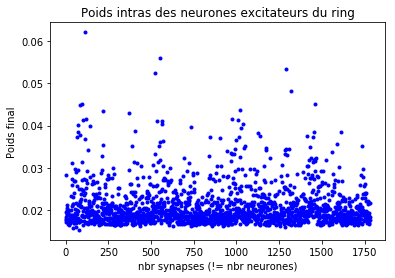

In [12]:
plt.plot(end_w, '.b')
plt.xlabel('nbr synapses (!= nbr neurones)')
plt.ylabel('Poids final')
plt.title('Poids intras des neurones excitateurs du ring')

Text(0.5, 1.0, 'Plasticité des neurones excitateurs du ring')

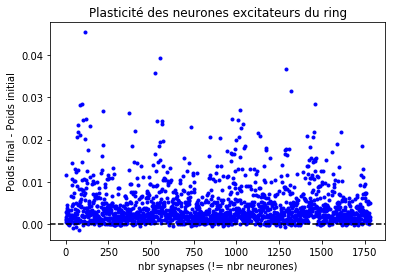

In [13]:
plt.plot(delta_w, '.b')
plt.axhline(0, c='k', linestyle = '--')
plt.xlabel('nbr synapses (!= nbr neurones)')
plt.ylabel('Poids final - Poids initial')
plt.title('Plasticité des neurones excitateurs du ring')